In [70]:
import csv
import numpy as np

images, labels = [], []

with open('train.csv') as train_file:
    # Skip first line.
    train_file.readline()
    
    csv_train_file = csv.reader(train_file, delimiter=',')
    for row in csv_train_file:
        labels.append(row[0])
        images.append(np.array(row[1:], dtype=float))

In [71]:
##############################################################
#           Part One: Preprocess Data 1) Explore
##############################################################

Printing sample with label 8.


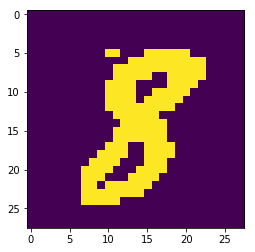

In [72]:
sample_index = 20

import matplotlib
from matplotlib import pyplot as plt

sample, label = images[sample_index], labels[sample_index]
plt.imshow(np.reshape(sample, (28, 28)), norm=matplotlib.colors.NoNorm())

print("Printing sample with label %s." % (label))
plt.show()

Printing sample with normalzied pixels.


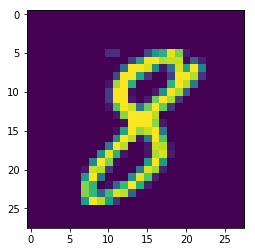

In [73]:
# Normalizing a sample to scale of (0, 1)

PIXEL_SCALE = 255
normalized_sample = sample / PIXEL_SCALE
plt.imshow(np.reshape(normalized_sample, (28, 28)), norm=matplotlib.colors.NoNorm())
print("Printing sample with normalzied pixels.")
plt.show()

In [135]:
normalized_images = [image / PIXEL_SCALE for image in images]

In [136]:
################################################################
#           Part One: Preprocess Data 2) Split Data Set
################################################################

In [137]:
# One hot encoding labels.
def one_hot_label(label):
    one_hot_coded = np.zeros(10)
    one_hot_coded[int(label)] = 1
    return np.array(one_hot_coded)

In [138]:
import random

combined = list(zip(images, labels))
random.shuffle(combined)
images[:], labels[:] = zip(*combined)

validation_size = int(len(images) / 10)

validate_images = [np.array(image).reshape((28, 28, 1)) for image in images[:validation_size]]
validate_labels = [one_hot_label(label) for label in labels[:validation_size]]

images = images[validation_size:]
labels = labels[validation_size:]


In [139]:
import tensorflow as tf

In [140]:
################################################################
#                Part Two: (1) Create Tensor
################################################################

In [141]:
def conv_net_input(input_shape):
    tensor_shape = [None] + list(input_shape)
    return tf.placeholder(tf.float32, shape=tensor_shape, name='conv_input')

def conv_net_label(label_shape):
    label_shape = [None, label_shape]
    return tf.placeholder(tf.float32, shape=label_shape, name='conv_label')

def conv_net_dropout_prob():
    return tf.placeholder(tf.float32, name='dropout_prob')

In [142]:
##############################################################
#                Part Two: (2) Create Layer
##############################################################

In [143]:
def bn_conv2d(input_tensor, kernel_depth=1, output_dim=32, k_size=3, padding='valid'):
    """
    :param input_tensor: input tensor, should be reshaped to 2D
    :param output_dim: output dimension, e.g. 32, 64, etc. 
    :param kernel_size: kernel size, 3, 5, etc.
    """
    
    print('bn_conv2d: ', input_tensor.get_shape().as_list())
    
    conv_layer = tf.layers.conv2d(input_tensor,
                                  output_dim,
                                  k_size,
                                  padding=padding,
                                  activation=tf.nn.relu)
    
    return tf.layers.batch_normalization(conv_layer, training=True)

In [144]:
def max_pool(input_tensor, pool_ksize, pool_strides, padding='valid'):
    return tf.layers.max_pooling2d(
        input_tensor,
        pool_ksize,
        pool_strides,
        padding
    )

In [145]:
from functools import reduce

def flatten(input_tensor):
    image_dimension = reduce(lambda a,b: a*b, input_tensor.get_shape().as_list()[1:])    
    return tf.reshape(input_tensor, [-1, image_dimension])

In [146]:
def fully_connected_with_dropout(input_tensor, output_dim, dropout):
    
    print('fully input_tensor:', input_tensor.get_shape().as_list())
    
    fully_connected = tf.layers.dense(
        input_tensor,
        output_dim,
    )
    
    dropout_layer = tf.layers.dropout(inputs=fully_connected, rate=dropout)    
    
    return dropout_layer

In [147]:
def output_layer(input_tensor, output_dim):    
    return tf.layers.dense(
        input_tensor,
        output_dim,
    )

In [148]:
class BatchLoader:
    
    def __init__(self, images=[], label=[]):
        self.images = images
        self.labels = labels
        self.offset = 0
        
    def load_batch_image(self, batch_size):
        i = self.offset
        image_batch = self.images[i: i + batch_size]
        image_batch = [image.reshape((28, 28, 1)) for image in image_batch]       
        self.offset += batch_size
        return image_batch
        
    def load_batch(self, batch_size):        
        i = self.offset
        image_batch = self.images[i: i + batch_size]
        image_batch = [image.reshape((28, 28, 1)) for image in image_batch]
                
        label_batch = self.labels[i: i + batch_size]
        label_batch = [one_hot_label(label) for label in label_batch]
        self.offset += batch_size
                
        return image_batch, label_batch
        
    def reset(self):
        self.offset = 0

In [149]:
##############################################################
#                Part Two: (3) Create Model
##############################################################

In [150]:
def conv_net(image, dropout_prob):
    """
    :param image: input image tensor.
    :dropout_prob: drop out probability.
    """
    # convolution - max pooling layer 1
    conv_layer = bn_conv2d(image, kernel_depth=1, output_dim=16, k_size=3)
    mp_layer = max_pool(conv_layer, 2, 2)
    
    # convolution - max pooling layer 2
    conv_layer = bn_conv2d(mp_layer, kernel_depth=16, output_dim=32, k_size=3)
    mp_layer = max_pool(conv_layer, 2, 2)
    
    # convolution - max pooling layer 3
    conv_layer = bn_conv2d(mp_layer, kernel_depth=32, output_dim=64, k_size=3)
    mp_layer = max_pool(conv_layer, 2, 2)
        
    flat = flatten(mp_layer)
    
    fully_conn = fully_connected_with_dropout(flat, 96, dropout_prob) 
        
    logits = output_layer(fully_conn, 10)
    
    return logits

In [151]:
##############################################################
#                Part Three: Define Loss & Accuracy
##############################################################

In [161]:
tf.reset_default_graph()

image_tensor = conv_net_input((28, 28, 1))
label_tensor = conv_net_label(10)
dropout_prob_tensor = conv_net_dropout_prob()

# Module

logits = conv_net(image_tensor, dropout_prob_tensor)
logits = tf.identity(logits, name='logits')

# Loss & Optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=label_tensor))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0004).minimize(loss)

correct_pred = tf.equal(tf.argmax(logits, axis=1), tf.argmax(label_tensor, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

bn_conv2d:  [None, 28, 28, 1]
bn_conv2d:  [None, 13, 13, 16]
bn_conv2d:  [None, 5, 5, 32]
fully input_tensor: [None, 64]


In [162]:
from functools import reduce
reduce((lambda a,b: a*b), [1,2], 1)

2

In [163]:
def print_stats(session,
                image_batch,
                label_batch,
                validation_image_batch,
                validation_label_batch,
                t_loss_seq,
                v_loss_seq
               ):
    
    t_loss = session.run(loss, feed_dict={
        image_tensor : image_batch,
        label_tensor : label_batch,
        dropout_prob_tensor : 0.0
    })
    
    t_loss_seq.append(t_loss)

    t_accuracy = session.run(accuracy, feed_dict={
        image_tensor : image_batch,
        label_tensor : label_batch,
        dropout_prob_tensor : 0.0     
    })
    
    v_loss = session.run(loss, feed_dict={
        image_tensor : validation_image_batch,
        label_tensor : validation_label_batch,
        dropout_prob_tensor : 0.0
    })
    
    v_loss_seq.append(v_loss)
    
    v_accuracy = session.run(accuracy, feed_dict={
        image_tensor : validation_image_batch,
        label_tensor : validation_label_batch,
        dropout_prob_tensor : 0.0     
    })
        
    print('Training loss: ', t_loss)
    print('Validation loss: ', v_loss)

    print('Training accuracy: ', t_accuracy)
    print('Validation accuracy: ', v_accuracy)



In [164]:
##############################################################
#                Part Four: Training
##############################################################

In [165]:
from matplotlib import pyplot as plt

In [166]:
def train_model(session, optimizer, image_batch, label_batch, dropout_prob):

    session.run(
        optimizer,
        feed_dict={
            image_tensor : image_batch,
            label_tensor : label_batch,
            dropout_prob_tensor : dropout_prob
        }
    )

In [167]:
save_model_path = './kaggle_digit'

def run_model(epochs, images, labels, batch_size, dropout_prob):
    
    t_loss_seq, v_loss_seq = [], []    
    
    with tf.Session() as session:
        
        # Initializing the variables
        session.run(tf.global_variables_initializer())
    
        # Prepare batches for images & labels
        loader = BatchLoader(images, labels)
    
        for epoch in range(epochs):
            
            loader.reset()
            
            count = 0
            
            while True:                
                image_batch, label_batch = loader.load_batch(batch_size)
                count += 1
                
                # Process each batch.
                if len(image_batch) != 0  and len(label_batch) != 0:                     
                    train_model(session, optimizer, image_batch, label_batch, dropout_prob)
                    
                    # Print stats every 7 epochs.
                    if count % 7 == 0:
                        print('===============epoch: ', epoch, '=================')
                        print_stats(session, image_batch, label_batch, 
                                    validate_images, validate_labels,
                                    t_loss_seq, v_loss_seq)
                        
                        ## Plot out training loss vs validation loss.
                        time_series = range(len(t_loss_seq))
                        plt.plot(time_series, t_loss_seq)
                        plt.plot(time_series, v_loss_seq)
                        plt.legend(['training_loss', 'validation_loss'])

                        plt.show()
                else:
                    break
                    
        saver = tf.train.Saver()
        save_path = saver.save(session, save_model_path)
                    


===============epoch:  0 =================
Training loss:  1.89219
Validation loss:  1.81195
Training accuracy:  0.346667
Validation accuracy:  0.386537


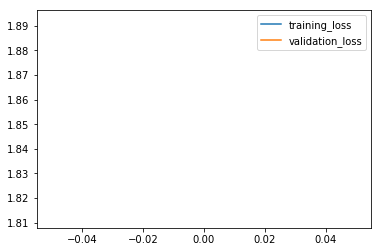

===============epoch:  0 =================
Training loss:  1.26166
Validation loss:  1.20808
Training accuracy:  0.6
Validation accuracy:  0.60729


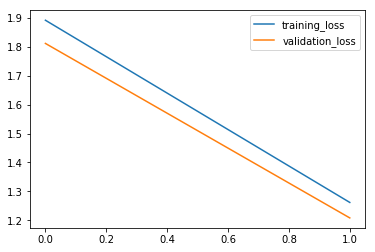

===============epoch:  0 =================
Training loss:  0.901689
Validation loss:  0.90283
Training accuracy:  0.735
Validation accuracy:  0.727219


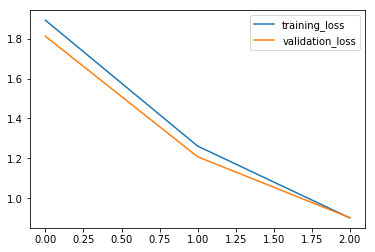

===============epoch:  0 =================
Training loss:  0.717712
Validation loss:  0.719899
Training accuracy:  0.78
Validation accuracy:  0.793357


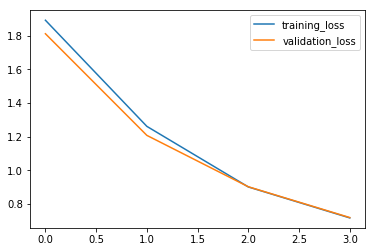

===============epoch:  0 =================
Training loss:  0.556434
Validation loss:  0.601291
Training accuracy:  0.855
Validation accuracy:  0.828924


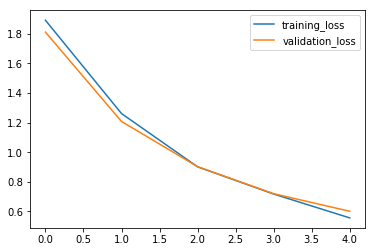

===============epoch:  0 =================
Training loss:  0.517256
Validation loss:  0.514406
Training accuracy:  0.851667
Validation accuracy:  0.851264


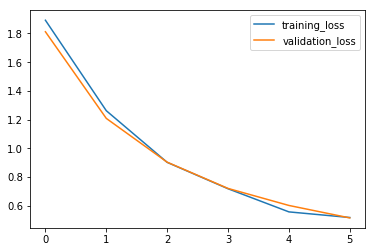

===============epoch:  0 =================
Training loss:  0.440731
Validation loss:  0.451827
Training accuracy:  0.881667
Validation accuracy:  0.866843


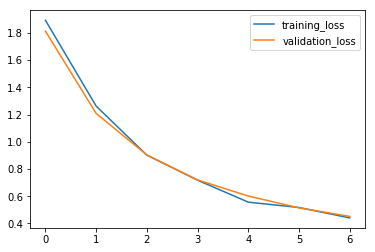

===============epoch:  1 =================
Training loss:  0.43059
Validation loss:  0.390034
Training accuracy:  0.876667
Validation accuracy:  0.880658


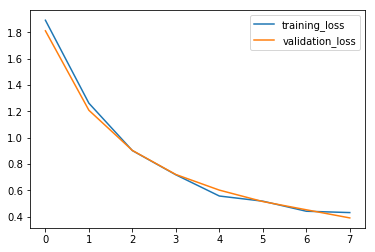

===============epoch:  1 =================
Training loss:  0.344469
Validation loss:  0.35419
Training accuracy:  0.895
Validation accuracy:  0.894768


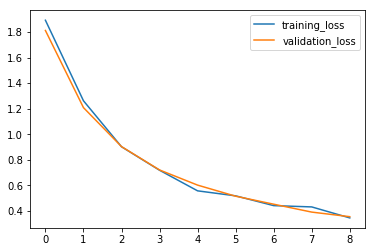

===============epoch:  1 =================
Training loss:  0.345085
Validation loss:  0.32345
Training accuracy:  0.903333
Validation accuracy:  0.904762


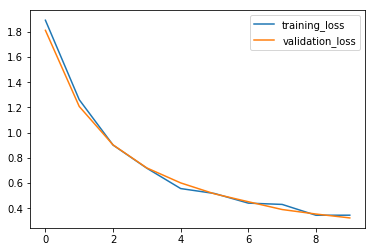

===============epoch:  1 =================
Training loss:  0.319237
Validation loss:  0.299063
Training accuracy:  0.908333
Validation accuracy:  0.914756


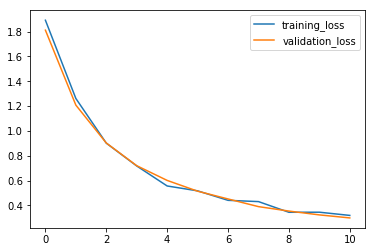

===============epoch:  1 =================
Training loss:  0.265813
Validation loss:  0.277968
Training accuracy:  0.91
Validation accuracy:  0.918871


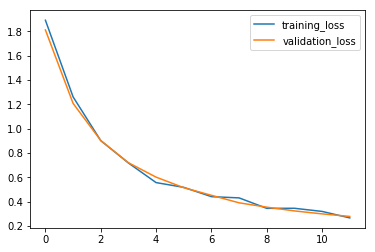

===============epoch:  1 =================
Training loss:  0.267767
Validation loss:  0.261144
Training accuracy:  0.918333
Validation accuracy:  0.922399


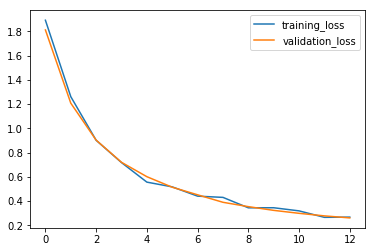

===============epoch:  1 =================
Training loss:  0.23802
Validation loss:  0.247875
Training accuracy:  0.943333
Validation accuracy:  0.924162


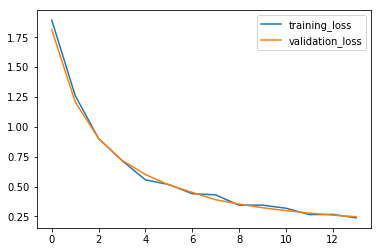

===============epoch:  2 =================
Training loss:  0.26059
Validation loss:  0.233514
Training accuracy:  0.925
Validation accuracy:  0.927102


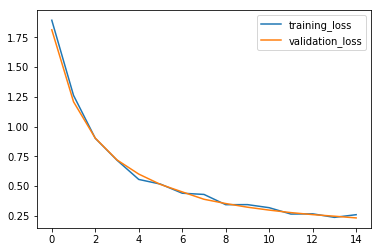

===============epoch:  2 =================
Training loss:  0.205061
Validation loss:  0.222454
Training accuracy:  0.94
Validation accuracy:  0.931511


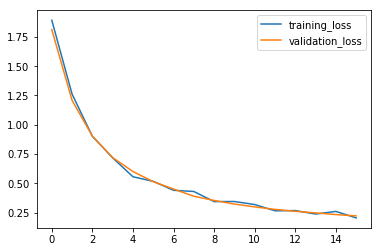

===============epoch:  2 =================
Training loss:  0.225396
Validation loss:  0.213485
Training accuracy:  0.933333
Validation accuracy:  0.932687


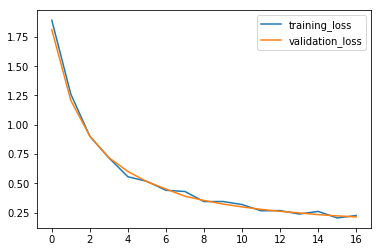

===============epoch:  2 =================
Training loss:  0.219066
Validation loss:  0.202853
Training accuracy:  0.936667
Validation accuracy:  0.936214


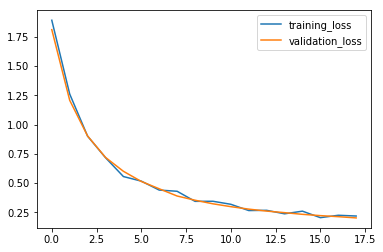

===============epoch:  2 =================
Training loss:  0.182958
Validation loss:  0.194533
Training accuracy:  0.936667
Validation accuracy:  0.940329


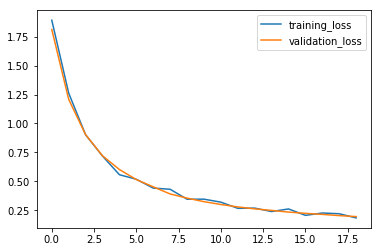

===============epoch:  2 =================
Training loss:  0.181278
Validation loss:  0.187158
Training accuracy:  0.945
Validation accuracy:  0.942387


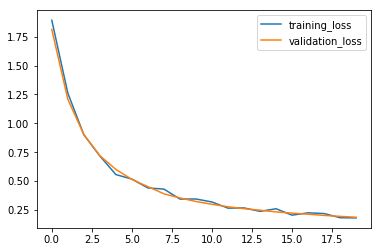

===============epoch:  2 =================
Training loss:  0.174285
Validation loss:  0.182096
Training accuracy:  0.96
Validation accuracy:  0.943563


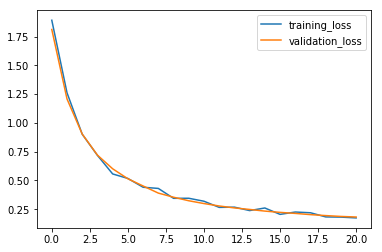

===============epoch:  3 =================
Training loss:  0.192215
Validation loss:  0.175221
Training accuracy:  0.951667
Validation accuracy:  0.944151


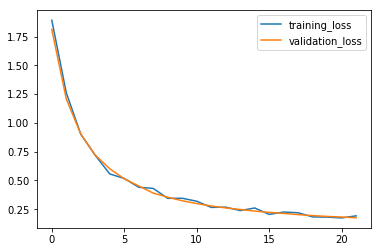

===============epoch:  3 =================
Training loss:  0.151906
Validation loss:  0.169739
Training accuracy:  0.958333
Validation accuracy:  0.944444


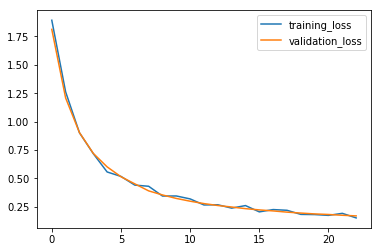

===============epoch:  3 =================
Training loss:  0.165064
Validation loss:  0.166054
Training accuracy:  0.95
Validation accuracy:  0.947972


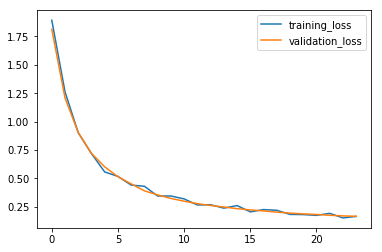

===============epoch:  3 =================
Training loss:  0.164594
Validation loss:  0.158947
Training accuracy:  0.955
Validation accuracy:  0.952381


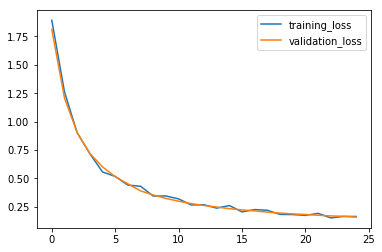

===============epoch:  3 =================
Training loss:  0.138541
Validation loss:  0.154701
Training accuracy:  0.955
Validation accuracy:  0.954439


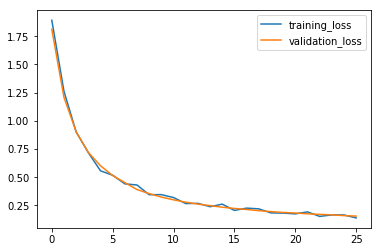

===============epoch:  3 =================
Training loss:  0.135812
Validation loss:  0.150648
Training accuracy:  0.965
Validation accuracy:  0.952969


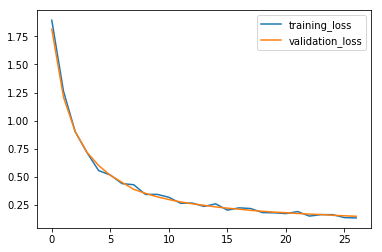

===============epoch:  3 =================
Training loss:  0.135141
Validation loss:  0.14749
Training accuracy:  0.961667
Validation accuracy:  0.953851


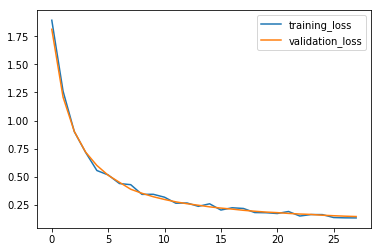

===============epoch:  4 =================
Training loss:  0.154601
Validation loss:  0.143
Training accuracy:  0.955
Validation accuracy:  0.95826


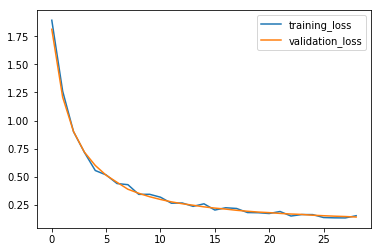

===============epoch:  4 =================
Training loss:  0.123342
Validation loss:  0.140033
Training accuracy:  0.963333
Validation accuracy:  0.957084


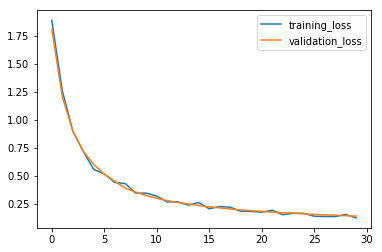

===============epoch:  4 =================
Training loss:  0.129261
Validation loss:  0.138656
Training accuracy:  0.96
Validation accuracy:  0.957378


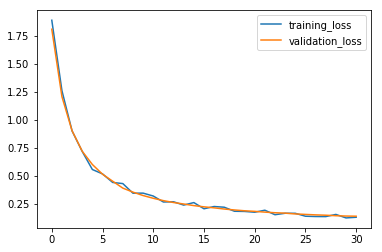

===============epoch:  4 =================
Training loss:  0.130555
Validation loss:  0.134294
Training accuracy:  0.968333
Validation accuracy:  0.957966


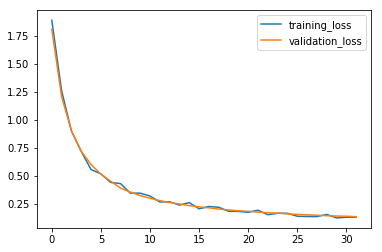

===============epoch:  4 =================
Training loss:  0.111421
Validation loss:  0.131592
Training accuracy:  0.97
Validation accuracy:  0.959142


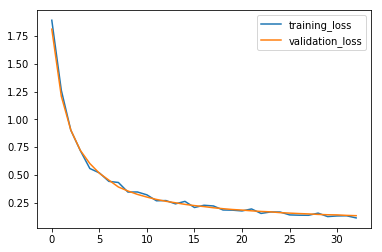

===============epoch:  4 =================
Training loss:  0.106445
Validation loss:  0.128799
Training accuracy:  0.971667
Validation accuracy:  0.959142


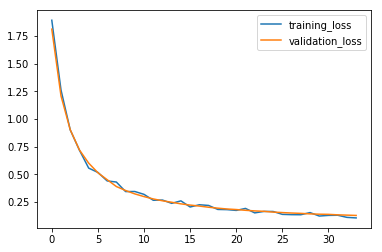

===============epoch:  4 =================
Training loss:  0.108217
Validation loss:  0.126181
Training accuracy:  0.966667
Validation accuracy:  0.960611


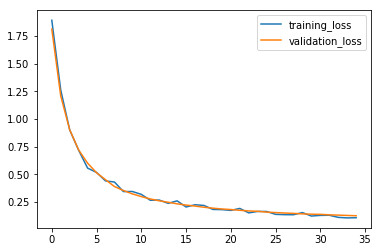

===============epoch:  5 =================
Training loss:  0.129025
Validation loss:  0.123563
Training accuracy:  0.956667
Validation accuracy:  0.963257


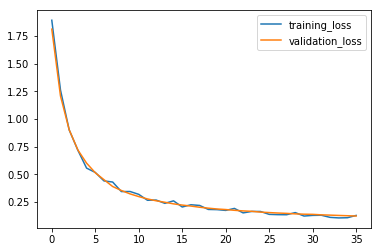

===============epoch:  5 =================
Training loss:  0.103045
Validation loss:  0.121891
Training accuracy:  0.971667
Validation accuracy:  0.963257


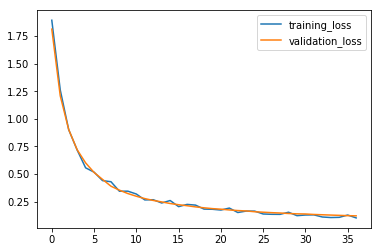

===============epoch:  5 =================
Training loss:  0.105816
Validation loss:  0.12129
Training accuracy:  0.971667
Validation accuracy:  0.962669


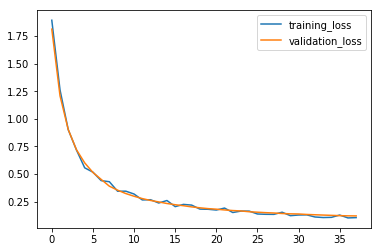

===============epoch:  5 =================
Training loss:  0.108198
Validation loss:  0.118094
Training accuracy:  0.97
Validation accuracy:  0.962669


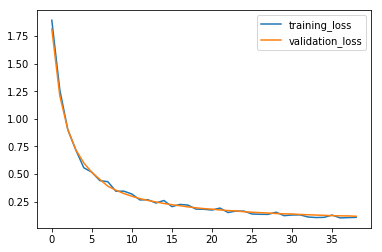

===============epoch:  5 =================
Training loss:  0.0933589
Validation loss:  0.116152
Training accuracy:  0.971667
Validation accuracy:  0.963551


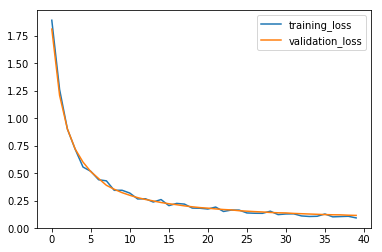

===============epoch:  5 =================
Training loss:  0.0845389
Validation loss:  0.11416
Training accuracy:  0.978333
Validation accuracy:  0.963551


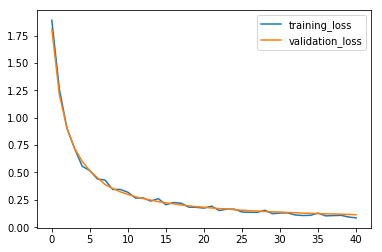

===============epoch:  5 =================
Training loss:  0.0885698
Validation loss:  0.111981
Training accuracy:  0.971667
Validation accuracy:  0.964139


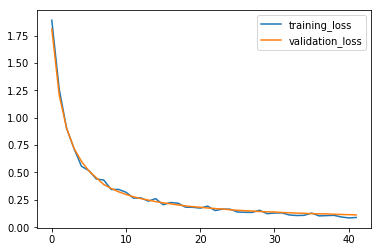

===============epoch:  6 =================
Training loss:  0.107778
Validation loss:  0.110042
Training accuracy:  0.968333
Validation accuracy:  0.967372


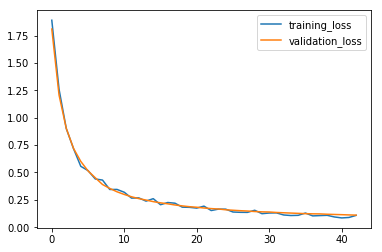

===============epoch:  6 =================
Training loss:  0.0888265
Validation loss:  0.108914
Training accuracy:  0.976667
Validation accuracy:  0.967372


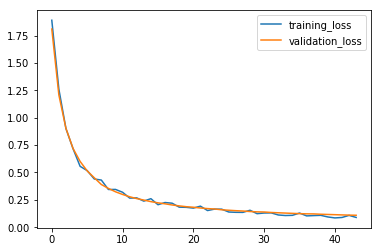

===============epoch:  6 =================
Training loss:  0.0899149
Validation loss:  0.10934
Training accuracy:  0.971667
Validation accuracy:  0.966196


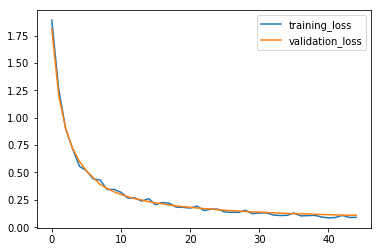

===============epoch:  6 =================
Training loss:  0.090608
Validation loss:  0.106835
Training accuracy:  0.97
Validation accuracy:  0.965902


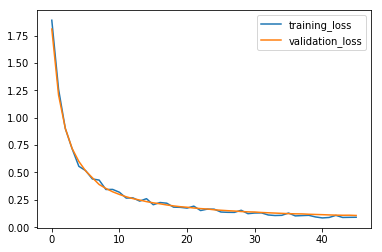

===============epoch:  6 =================
Training loss:  0.0812882
Validation loss:  0.105494
Training accuracy:  0.973333
Validation accuracy:  0.965608


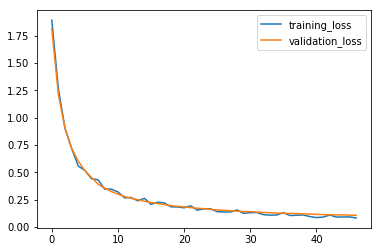

===============epoch:  6 =================
Training loss:  0.0677493
Validation loss:  0.103676
Training accuracy:  0.98
Validation accuracy:  0.966196


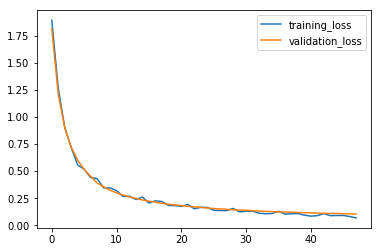

===============epoch:  6 =================
Training loss:  0.0746594
Validation loss:  0.102072
Training accuracy:  0.981667
Validation accuracy:  0.967666


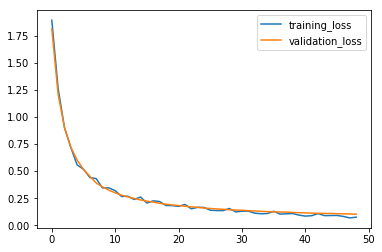

===============epoch:  7 =================
Training loss:  0.0921716
Validation loss:  0.101011
Training accuracy:  0.973333
Validation accuracy:  0.969136


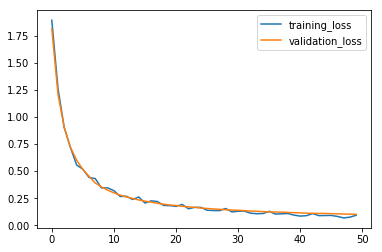

===============epoch:  7 =================
Training loss:  0.077222
Validation loss:  0.100065
Training accuracy:  0.978333
Validation accuracy:  0.969724


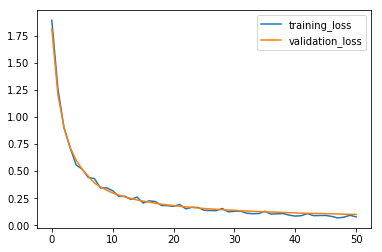

===============epoch:  7 =================
Training loss:  0.077647
Validation loss:  0.100801
Training accuracy:  0.975
Validation accuracy:  0.968842


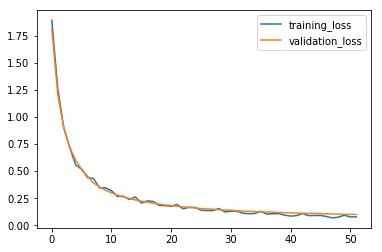

===============epoch:  7 =================
Training loss:  0.0769175
Validation loss:  0.0986255
Training accuracy:  0.976667
Validation accuracy:  0.967078


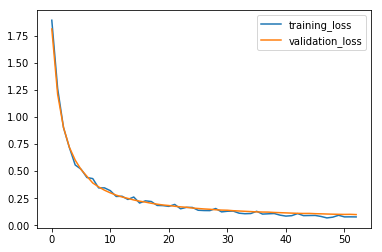

===============epoch:  7 =================
Training loss:  0.0696231
Validation loss:  0.0974694
Training accuracy:  0.978333
Validation accuracy:  0.968548


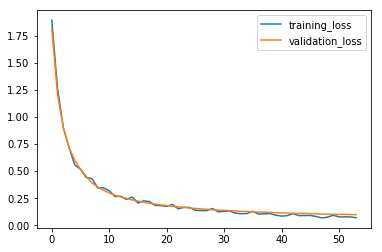

===============epoch:  7 =================
Training loss:  0.0553687
Validation loss:  0.0963516
Training accuracy:  0.983333
Validation accuracy:  0.96943


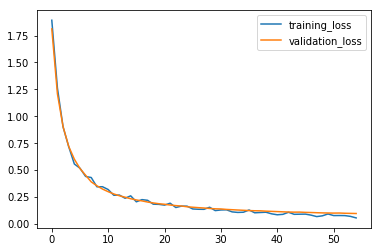

===============epoch:  7 =================
Training loss:  0.0647496
Validation loss:  0.0949424
Training accuracy:  0.981667
Validation accuracy:  0.970312


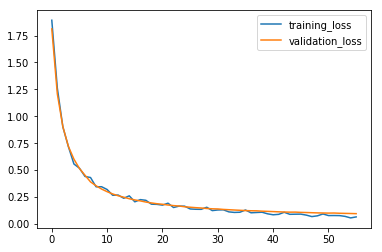

===============epoch:  8 =================
Training loss:  0.0789746
Validation loss:  0.0940513
Training accuracy:  0.98
Validation accuracy:  0.970606


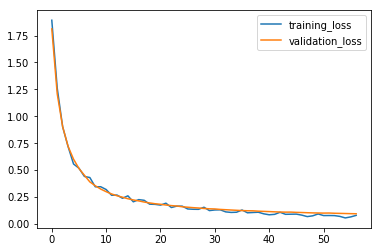

===============epoch:  8 =================
Training loss:  0.0665953
Validation loss:  0.0937273
Training accuracy:  0.98
Validation accuracy:  0.970606


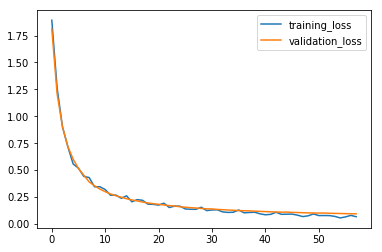

===============epoch:  8 =================
Training loss:  0.0677506
Validation loss:  0.0949613
Training accuracy:  0.976667
Validation accuracy:  0.970606


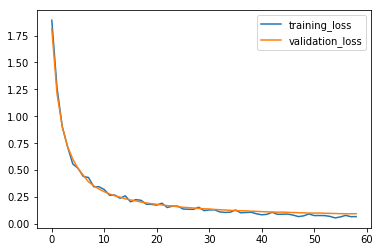

===============epoch:  8 =================
Training loss:  0.0658807
Validation loss:  0.093229
Training accuracy:  0.976667
Validation accuracy:  0.96943


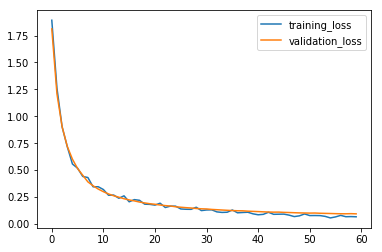

===============epoch:  8 =================
Training loss:  0.0605735
Validation loss:  0.0922247
Training accuracy:  0.983333
Validation accuracy:  0.970018


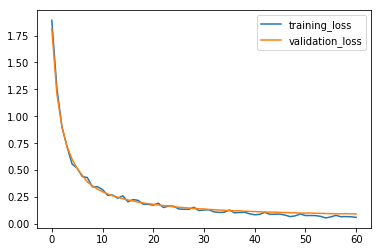

===============epoch:  8 =================
Training loss:  0.046415
Validation loss:  0.0913089
Training accuracy:  0.988333
Validation accuracy:  0.971193


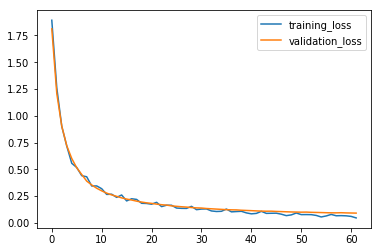

===============epoch:  8 =================
Training loss:  0.0563507
Validation loss:  0.0898139
Training accuracy:  0.985
Validation accuracy:  0.972369


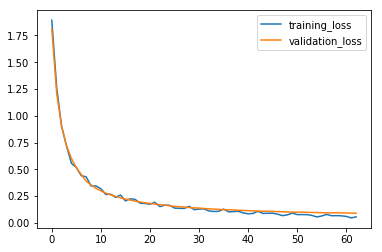

===============epoch:  9 =================
Training loss:  0.0679194
Validation loss:  0.0889038
Training accuracy:  0.983333
Validation accuracy:  0.973839


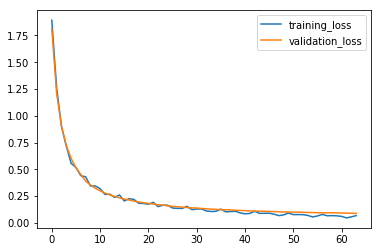

===============epoch:  9 =================
Training loss:  0.0565558
Validation loss:  0.0890165
Training accuracy:  0.983333
Validation accuracy:  0.972369


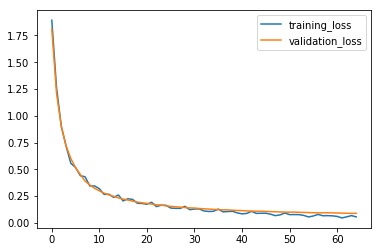

===============epoch:  9 =================
Training loss:  0.0575451
Validation loss:  0.0905837
Training accuracy:  0.98
Validation accuracy:  0.972075


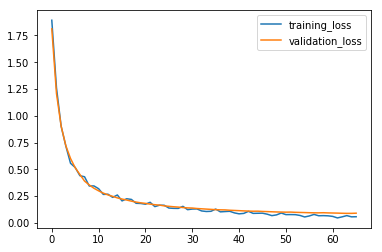

===============epoch:  9 =================
Training loss:  0.0559643
Validation loss:  0.0889543
Training accuracy:  0.98
Validation accuracy:  0.971193


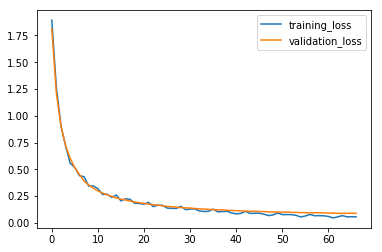

===============epoch:  9 =================
Training loss:  0.0536676
Validation loss:  0.0883629
Training accuracy:  0.985
Validation accuracy:  0.970606


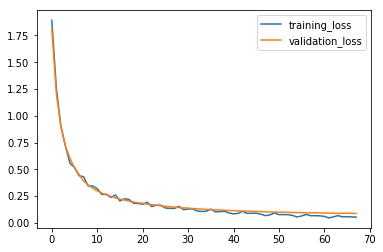

===============epoch:  9 =================
Training loss:  0.0399704
Validation loss:  0.0877654
Training accuracy:  0.99
Validation accuracy:  0.972369


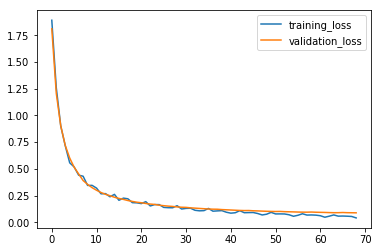

===============epoch:  9 =================
Training loss:  0.0501882
Validation loss:  0.0866187
Training accuracy:  0.986667
Validation accuracy:  0.973839


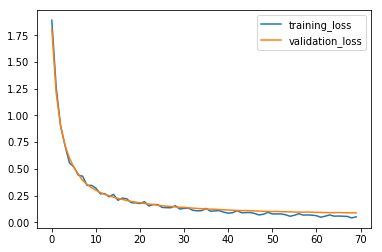

===============epoch:  10 =================
Training loss:  0.0597559
Validation loss:  0.085388
Training accuracy:  0.983333
Validation accuracy:  0.973839


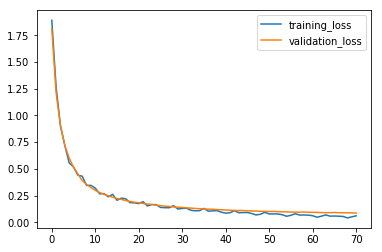

===============epoch:  10 =================
Training loss:  0.0479117
Validation loss:  0.085603
Training accuracy:  0.985
Validation accuracy:  0.974427


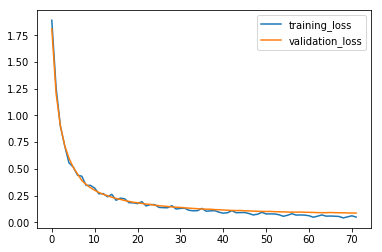

===============epoch:  10 =================
Training loss:  0.0481459
Validation loss:  0.0877614
Training accuracy:  0.985
Validation accuracy:  0.972369


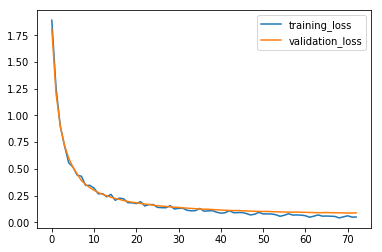

===============epoch:  10 =================
Training loss:  0.048676
Validation loss:  0.0863704
Training accuracy:  0.98
Validation accuracy:  0.971781


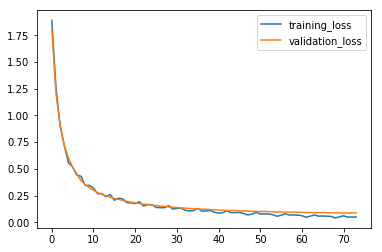

===============epoch:  10 =================
Training loss:  0.047045
Validation loss:  0.0863065
Training accuracy:  0.985
Validation accuracy:  0.971487


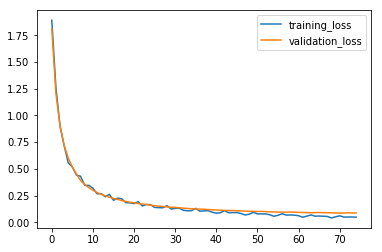

===============epoch:  10 =================
Training loss:  0.0344943
Validation loss:  0.0858356
Training accuracy:  0.991667
Validation accuracy:  0.972957


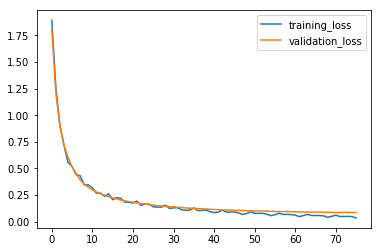

===============epoch:  10 =================
Training loss:  0.0435662
Validation loss:  0.0843994
Training accuracy:  0.99
Validation accuracy:  0.974427


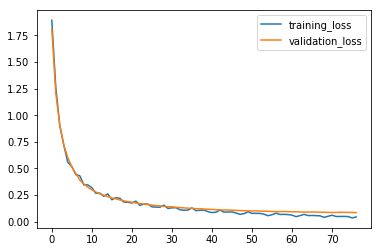

===============epoch:  11 =================
Training loss:  0.0516782
Validation loss:  0.0828197
Training accuracy:  0.986667
Validation accuracy:  0.974427


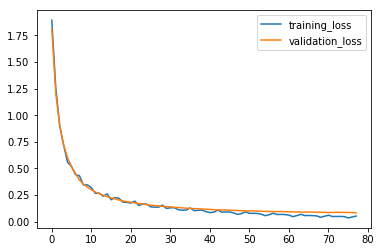

===============epoch:  11 =================
Training loss:  0.0399079
Validation loss:  0.0831381
Training accuracy:  0.988333
Validation accuracy:  0.974721


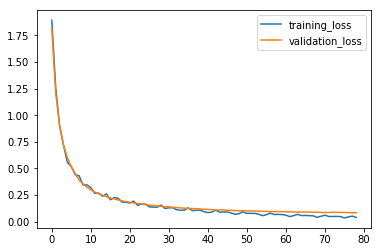

===============epoch:  11 =================
Training loss:  0.0400295
Validation loss:  0.0855316
Training accuracy:  0.99
Validation accuracy:  0.973839


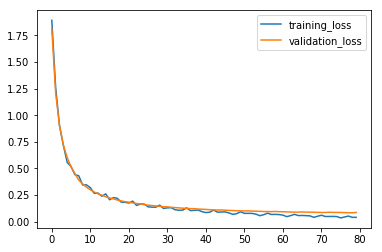

===============epoch:  11 =================
Training loss:  0.041688
Validation loss:  0.0835338
Training accuracy:  0.983333
Validation accuracy:  0.973251


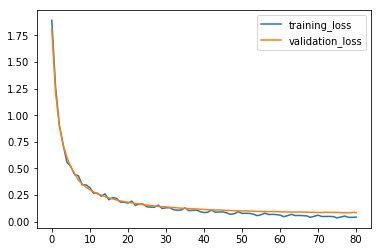

===============epoch:  11 =================
Training loss:  0.0412125
Validation loss:  0.0836097
Training accuracy:  0.988333
Validation accuracy:  0.974721


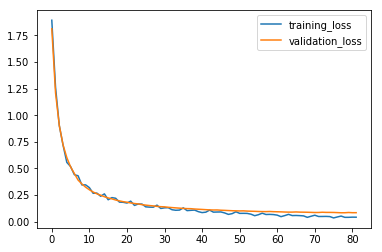

===============epoch:  11 =================
Training loss:  0.0298734
Validation loss:  0.0835549
Training accuracy:  0.991667
Validation accuracy:  0.973839


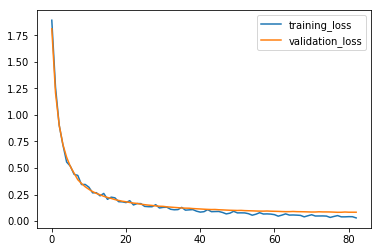

===============epoch:  11 =================
Training loss:  0.0374625
Validation loss:  0.0827922
Training accuracy:  0.99
Validation accuracy:  0.974721


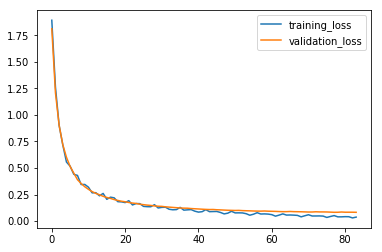

===============epoch:  12 =================
Training loss:  0.0461237
Validation loss:  0.0812824
Training accuracy:  0.986667
Validation accuracy:  0.975603


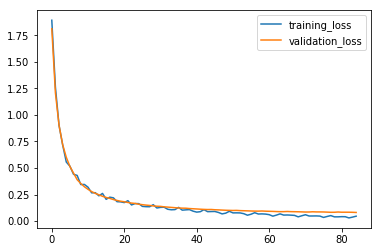

===============epoch:  12 =================
Training loss:  0.0339075
Validation loss:  0.0818683
Training accuracy:  0.991667
Validation accuracy:  0.975603


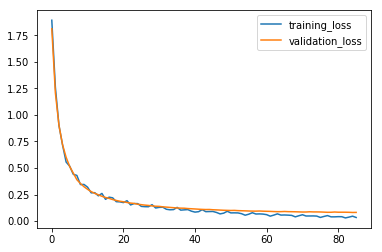

===============epoch:  12 =================
Training loss:  0.0338948
Validation loss:  0.0843619
Training accuracy:  0.995
Validation accuracy:  0.973545


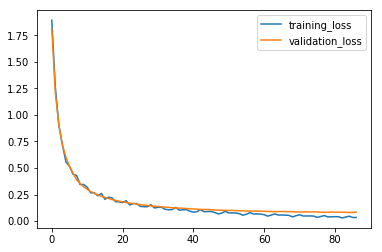

===============epoch:  12 =================
Training loss:  0.0354053
Validation loss:  0.0818578
Training accuracy:  0.986667
Validation accuracy:  0.975015


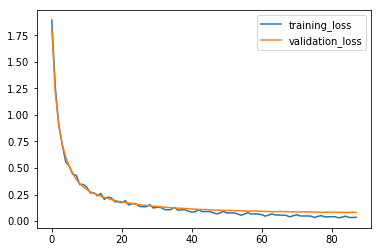

In [ ]:
run_model(13, images, labels, 600, 0.3)

In [133]:
##############################################################
#                Part Five: Testing 
##############################################################

In [50]:
test_images = []

with open('test.csv') as test_file:
    # Skip first line.
    test_file.readline()
    
    csv_test_file = csv.reader(test_file, delimiter=',')
    for row in csv_test_file:
        test_images.append(np.array(row, dtype=float))

In [51]:
t_offset = 1

with open('test_output.csv', 'w') as test_output:
    test_output.write('ImageId,Label\n')
    
    test_loader = BatchLoader(test_images)

    
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)
        
        loaded_image_tensor = loaded_graph.get_tensor_by_name("conv_input:0")
        loaded_label_tensor = loaded_graph.get_tensor_by_name("conv_label:0")
        loaded_dropout_prob = loaded_graph.get_tensor_by_name("dropout_prob:0")
        loaded_logits = loaded_graph.get_tensor_by_name("logits:0")
    
        while True:
            test_image_batch = test_loader.load_batch_image(600)
            
            if len(test_image_batch) == 0:
                break
            
            labels = sess.run(loaded_logits, feed_dict={
                loaded_image_tensor: test_image_batch,
                loaded_dropout_prob: 0.0
            })
        
            labels = np.argmax(labels, axis=1)
        
            data = zip(range(t_offset, t_offset + len(labels)), labels)
        
            for d in data:
                test_output.write('%d,%d\n' % d)
            
            t_offset += len(labels)
        

INFO:tensorflow:Restoring parameters from ./kaggle_digit
